In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import fftpack

In [3]:
# matplotlib parameters 
large = 40; med = 20; small = 20
params = {'axes.titlesize': med,'axes.titlepad' : med,
          'legend.fontsize': med,'axes.labelsize': med ,
          'axes.titlesize': med ,'xtick.labelsize': med ,
          'ytick.labelsize': med ,'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
#plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

# GP solver

In [4]:
PI = np.pi
H_BAR = 1.0545718 * 10 ** (-34)

class GrossPitaevskiiSolver:
    def __init__(self, time_step, tmax, position_arr, potential_func, number_of_atoms, initial_wavefunction):

        self.h_bar = 1.0545718 * 10 ** (-34)

        # Transistor parameters.
        self.omega_r = 2 * np.pi * 300  # rad/s # Radial trapping frequency.
        self.omega_l = 2 * np.pi * 20  # rad/s # Longitudinal trapping frequency.
        self.number_of_atoms = number_of_atoms # Number of atoms in the trap.
        self.atom_mass = 1.4192261 * 10 ** (-25)  # kg # Mass of Rubidium-87 atom.
        self.a_s = 5.82*1.e-9 # m # Scattering length of Rubidium-87 atom.

        # Parameters for the dimensionless form of the Gross-Pitaevskii equation.
        self.l_0 = np.sqrt(self.h_bar / (self.atom_mass * self.omega_l))
        self.t_0 = 1 / self.omega_l

        self.a = self.a_s/self.l_0

        if self.a_s > self.l_0: # Ref: PRL 85, 3745 (2000).
            raise ValueError(f"a_s ({self.a_s}) must be less than l_0 ({self.l_0}).")

        self.g_dimless = 2*(self.omega_r/self.omega_l)*self.a*self.number_of_atoms
        
        if 4 * np.pi * self.a_s * self.number_of_atoms < self.l_0:
            raise ValueError(f"4*np.pi*a_s*number_of_atoms ({4 * np.pi * self.a_s * self.number_of_atoms}) must be greater than a_0 ({self.l_0}).")

        number_density = self.number_of_atoms / (np.pi * self.l_0 ** 2 * (np.ptp(position_arr)))

        # Dilue gas condition for the Gross-Pitaevskii equation.
        if number_density * self.a_s ** 3 > 1:
            raise ValueError(f"Gross-Pitaevskii equation is valid if: {number_density * self.a_s ** 3} << 1")
        else:
            print(f"Gross-Pitaevskii equation is valid: {number_density * self.a_s ** 3} << 1")

        self.time_step = time_step
        self.tmax = tmax
        self.position_arr = position_arr
        self.potential_func = potential_func

        self.N = len(self.position_arr)
        self.dx = np.ptp(self.position_arr) / self.N

        self.position_arr_dimless = self.position_arr / self.l_0
        self.dx_dimless = self.dx / self.l_0
        self.L_dimless = np.ptp(self.position_arr_dimless)
        self.dk_dimless = (2 * np.pi) / self.L_dimless
        self.time_step_dimless = self.time_step / self.t_0
        self.tmax_dimless = self.tmax / self.t_0

        def normalize(psi_x_dimless):
            return psi_x_dimless / np.sqrt(np.sum(np.abs(psi_x_dimless) ** 2) * self.dx_dimless)
            
        if initial_wavefunction is None:
            print("Initial wavefunction is not provided. Using a Gaussian wavefunction as the initial wavefunction.")
            amplitude = 1.0
            mean = np.mean(self.position_arr_dimless)
            std_dev = 0.1
            psi_initial_dimless = amplitude * np.exp(-(self.position_arr_dimless - mean) ** 2 / (2 * std_dev ** 2)) * np.sqrt(self.l_0)
            self.psi_x_dimless = normalize(psi_initial_dimless)
        else:
            # The wavefunction must have dimensions of [1/length]^(1/2).
            initial_wavefunction_dimless = initial_wavefunction * np.sqrt(self.l_0)
            self.psi_x_dimless = normalize(initial_wavefunction_dimless)
            print("Normalization of the initial wavefunction = ", np.sum(np.abs(self.psi_x_dimless) ** 2) * self.dx_dimless)

    def hamiltonian_x_dimless(self, potential_func, psi_x_dimless):
        return potential_func/(self.h_bar * self.omega_l) + self.g_dimless * np.abs(psi_x_dimless) ** 2

    def kinetic_energy_dimless(self):
        k_dimless = np.hstack([np.arange(0, self.N / 2), np.arange(-self.N / 2, 0)]) * self.dk_dimless
        if len(k_dimless) != self.N:
            k_dimless = np.hstack([np.arange(0, self.N / 2), np.arange(-self.N / 2 + 1, 0)]) * self.dk_dimless
        return k_dimless ** 2 / 2

    def number_of_atoms_interval(self, psi_time_evolved, a, b):

        def normalize(psi_x_dimless):
                return psi_x_dimless / np.sqrt(np.sum(np.abs(psi_x_dimless) ** 2) * self.dx_dimless)
                
        psi_time_evolved = normalize(psi_time_evolved)
        a_dimless = a*1.e-6 / self.l_0
        b_dimless = b*1.e-6 / self.l_0
        psi_from_a_to_b_dimless = psi_time_evolved[np.logical_and(self.position_arr_dimless >= a_dimless, self.position_arr_dimless <= b_dimless)]
        return (self.number_of_atoms)*np.sum(np.abs(psi_from_a_to_b_dimless)**2)*self.dx_dimless


    def solve(self, snapshots_lst):

        total_iterations = int(np.abs(self.tmax_dimless) / np.abs(self.time_step_dimless))
        print('Total iterations: ', total_iterations)

        def normalize(psi_x_dimless):
            return psi_x_dimless / np.sqrt(np.sum(np.abs(psi_x_dimless) ** 2) * self.dx_dimless)

        transistor_position_arr = self.position_arr
        if snapshots_lst:

            source_well_atom_number_arr = []
            gate_well_atom_number_arr = []
            drain_well_atom_number_arr = []

        if snapshots_lst:
            snapshot_index = 0
            time = snapshots_lst[snapshot_index]  # Starting time.
            
        for iteration in range(total_iterations):

            self.psi_x_dimless = np.exp(-self.hamiltonian_x_dimless(self.potential_func, self.psi_x_dimless) * 1j * self.time_step_dimless / 2) * self.psi_x_dimless
            self.psi_x_dimless = normalize(self.psi_x_dimless)
            psi_k_dimless = fftpack.fft(self.psi_x_dimless)
            psi_k_dimless = np.exp(-(self.kinetic_energy_dimless() * 1j * self.time_step_dimless)) * psi_k_dimless

            self.psi_x_dimless = fftpack.ifft(psi_k_dimless)
            self.psi_x_dimless = normalize(self.psi_x_dimless)
            self.psi_x_dimless = np.exp(-self.hamiltonian_x_dimless(self.potential_func, self.psi_x_dimless) * 1j * self.time_step_dimless / 2) * self.psi_x_dimless
            self.psi_x_dimless = normalize(self.psi_x_dimless)

            if snapshots_lst:
                
                if np.isclose(time, snapshots_lst[snapshot_index]):
                    snapshot_index += 1
                    time_evolved_wavefunction_time_split_dimless = self.psi_x_dimless                                            
                    path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
                    os.chdir(path)
                    print(f"Saved snapshot at {time*1e3:.3f} ms")
                    np.save(f"wavefunction_time_evolved_{time*1e3:.3f}ms.npy", time_evolved_wavefunction_time_split_dimless)

                    # Saving the atom number in each well at each time t in the list.
                    number_of_atoms_in_source_well = self.number_of_atoms_interval(time_evolved_wavefunction_time_split_dimless, source_well_start, gate_well_start)
                    number_of_atoms_in_gate_well = self.number_of_atoms_interval(time_evolved_wavefunction_time_split_dimless, gate_well_start, gate_well_end)  
                    number_of_atoms_in_drain_well = self.number_of_atoms_interval(time_evolved_wavefunction_time_split_dimless, gate_well_end, drain_well_end)

                    source_well_atom_number_arr.append(number_of_atoms_in_source_well)
                    gate_well_atom_number_arr.append(number_of_atoms_in_gate_well)
                    drain_well_atom_number_arr.append(number_of_atoms_in_drain_well)

                    if snapshot_index >= len(snapshots_lst):
                        break             
                           
                time += self.time_step  

        print("Normalization of the final single particle wavefunction: ", np.sum(np.abs(self.psi_x_dimless) ** 2) * self.dx_dimless)
        print("Number of atoms in the trap = ", (self.number_of_atoms)*np.sum(np.abs(self.psi_x_dimless) ** 2) * self.dx_dimless)
        if snapshots_lst:
            path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
            os.chdir(path)
        #     np.save("wavefunction_at_fixed_point_source_arr.npy",wavefunction_at_fixed_point_source_arr) 
        #     np.save("wavefunction_at_fixed_point_gate_arr.npy",wavefunction_at_fixed_point_gate_arr)
        #     np.save("wavefunction_at_fixed_point_drain_arr.npy",wavefunction_at_fixed_point_drain_arr)
        
            np.save("source_well_atom_number_arr.npy",source_well_atom_number_arr)
            np.save("gate_well_atom_number_arr.npy",gate_well_atom_number_arr)
            np.save("drain_well_atom_number_arr.npy",drain_well_atom_number_arr)

        return normalize(self.psi_x_dimless)

# Setting up the triple well potential landscape

In [5]:
# Number of points in the grid.
N = 2**14

V_infinity  = 1.e4 # In kHz units.

# Position parameters in micrometers.
position_start      = -60
source_well_start   = -50
gate_well_start     = 0
gate_well_end       = 4.8
drain_well_end      = 990
position_end        = 1000

path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
os.chdir(path)
np.save("position_start.npy",position_start)
np.save("position_end.npy",position_end)
np.save("source_well_start.npy",source_well_start)
np.save("gate_well_start.npy",gate_well_start)
np.save("gate_well_end.npy",gate_well_end)
np.save("drain_well_end.npy",drain_well_end)

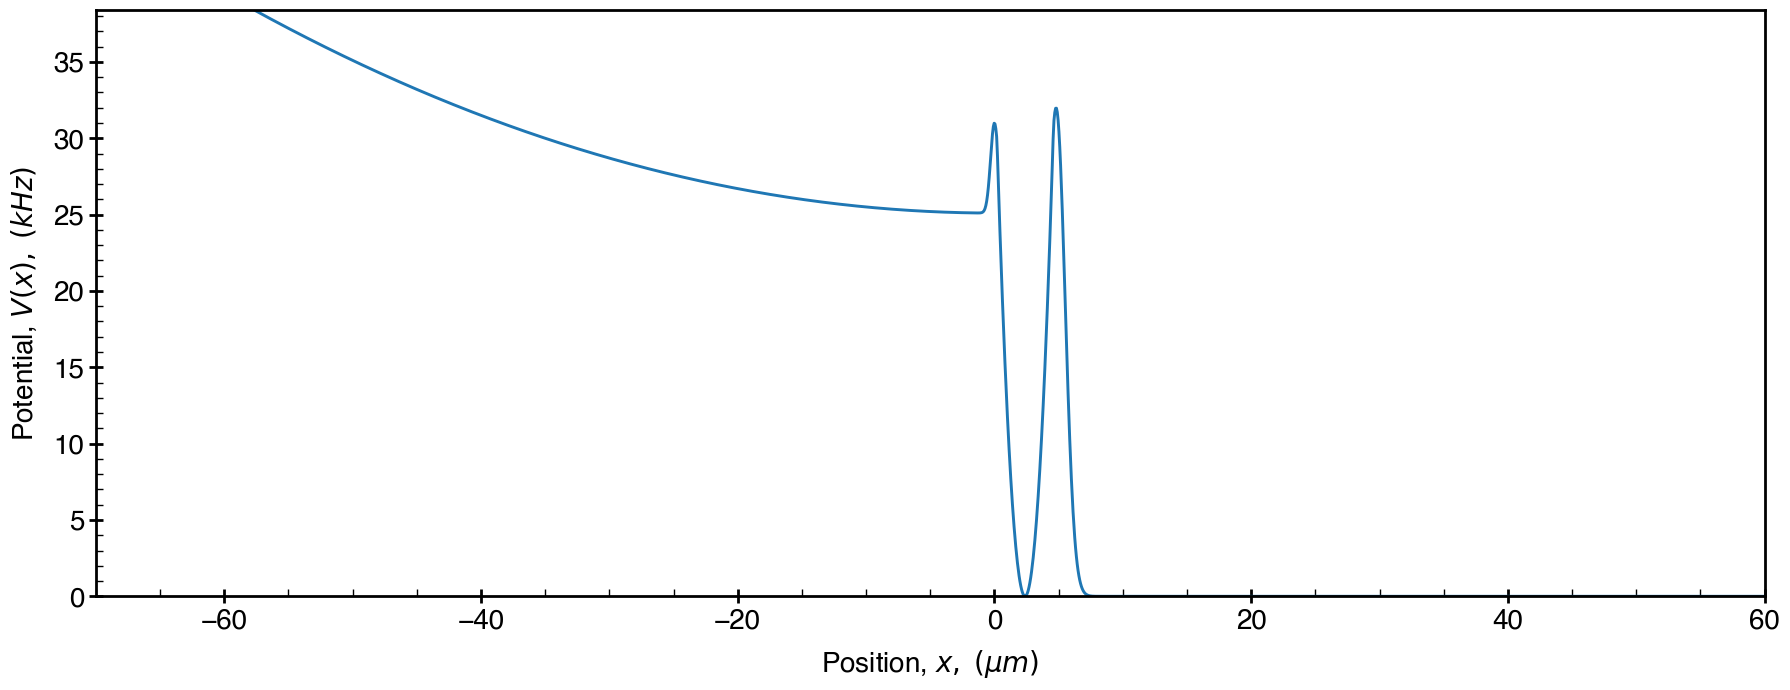

In [6]:
def left_tanh_function(xs, barrier_height, x_0, smoothness_control_parameter):
     """
     This function creates a smooth potential barrier with zero potential on the right of a given position x_0.

     Parameters
     ----------
          xs : array 
               The x-axis values.
          barrier_height : float
                The height of the barrier.
          x_0 : float 
               The position of the barrier.
          smoothness_control_parameter : float 
               The smoothness of the barrier. 

     Returns
     -------
          array
               The potential barrier.

     """     
     return barrier_height/2 - barrier_height/2 * np.tanh((xs-x_0)/(barrier_height*smoothness_control_parameter))

def right_tanh_function(xs, barrier_height, x_0, smoothness_control_parameter):
     """
     This function creates a smooth potential barrier with zero potential on the left of a given position x_0.

     Parameters
     ----------
          xs : array
               The x-axis values.
          barrier_height : float
                The height of the barrier.
          x_0 : float
               The position of the barrier.
          smoothness_control_parameter : float
               The smoothness of the barrier.
               
     Returns
     -------
          array
               The potential barrier

     """
     return barrier_height/2 + barrier_height/2 * np.tanh((xs-x_0)/(smoothness_control_parameter))

def different_plataeu_gaussian_barrier(x, x_0, barrier_height, left_plataeu_height, right_plataeu_height, sigma_1, sigma_2):
     """

     This function creates a Gaussian barrier centered at x_0 with a given barrier height with two different potential plateaus on the left and right of the barrier.

     Parameters
     ----------
          x : array
               The x-axis values.  
          x_0 : float
               The position of the barrier.
          barrier_height : float
               The height of the barrier.
          left_plataeu_height : float
               The height of the left plateau.
          right_plataeu_height : float
               The height of the right plateau.
          sigma_1 : float
               The width of the Gaussian barrier.
          sigma_2 : float
               The width of the tanh function.

     Returns
     -------
          array
               The potential barrier.
               
     """     
     return (barrier_height)*np.exp(-((x-x_0)/sigma_1)**2) + (left_plataeu_height + right_plataeu_height)/2 - (left_plataeu_height - right_plataeu_height)/2 * np.tanh((x-x_0)/(sigma_2))     


def source_well_potential_function(x, A, B, C, bias_potential_in_source_well):
     """ 
     This function creates a source well potential with a Gaussian barrier.

     Parameters
     ----------
          x : array
               The x-axis values.
          A : float
               Controls the width of the source well.
          B : float
               Controls the width of the SG barrier.
          C : float
               Controls the height of the SG barrier.
          bias_potential_in_source_well : float
               The bias potential in the source well.

     Returns
     -------
          array
               The source well potential.
     
     """
     return A*x**2+C*np.exp(-x**2/B)+bias_potential_in_source_well     

def harmonic_well(x1,y1,x2,y2,x3,y3):

     """
     This function returns the coefficients of a harmonic well equation given three points on the well.

     Parameters
     ----------
          x1 : float
               x-coordinate of the first point.
          y1 : float
               y-coordinate of the first point.
          x2 : float
               x-coordinate of the second point.
          y2 : float
               y-coordinate of the second point.
          x3 : float
               x-coordinate of the third point.
          y3 : float
               y-coordinate of the third point.

     Returns
     -------
          (float, float, float)
               The coefficients of the harmonic well equation. The harmonic well
               equation is given by c1*x**2 + c2*x + c3.
     """
     A = np.array([[x1**2, x1, 1],
                   [x2**2, x2, 1],
                   [x3**2, x3, 1]])
     b = np.array([y1, y2, y3])
     c1, c2, c3 = np.linalg.solve(A, b)
     return c1, c2, c3     

def transistor_potential_landscape(V_SS,  position_arr, SG_barrier_height, GD_barrier_height, gate_bias_potential,
     SIGMA_1 = 0.6,
     SIGMA_2 = 0.8,
     SIGMA_3 = 1.0,
     SIGMA_4 = 0.6,
     ):

     """
     This function creates a potential landscape for a transistor with a source well, gate well, and a drain well.

     Parameters
     ----------
          V_SS : float
               The bias potential in the source well.
          position_arr : array
               The x-axis values.
          SG_barrier_height : float
               The height of the SG barrier.
          GD_barrier_height : float
               The height of the GD barrier.
          gate_bias_potential : float
               The bias potential in the gate well.
          SIGMA_1 : float
               The width of the Gaussian barrier.
          SIGMA_2 : float
               The width of the tanh function.
          SIGMA_3 : float
               The width of the Gaussian barrier.
          SIGMA_4 : float
               The width of the tanh function.

     Returns
     -------
          array

     """

     # These are two offsets that makes the top of the V_SG and V_GD barriers smooth.
     delta_left = 0.2
     delta_right = 0.2

     # Creating the source well.
     A = 0.004 # Increasing A results in decrease in width of the source well.
     B = 0.18 # Increasing B results in increase in width of the SG barrier.
     potential = np.zeros(len(position_arr))
     potential = np.where(position_arr <= gate_well_start + delta_left, source_well_potential_function(position_arr, A, B, SG_barrier_height - V_SS,V_SS), potential)

     # Creating the gate well.
     ## First point on the left side of the gate well.
     x_1 = gate_well_start + delta_left
     y_1 = source_well_potential_function(x_1, A, B, SG_barrier_height - V_SS, V_SS)

     ## Second point at the end of the gate well.
     x_2 = gate_well_end - delta_right
     y_2 = different_plataeu_gaussian_barrier(gate_well_end - delta_right, gate_well_end, GD_barrier_height, 0,0, SIGMA_3, SIGMA_4)

     ## Third point at the center of the gate well.
     x_3 = (gate_well_start + gate_well_end)/2
     y_3 = gate_bias_potential

     """ Harmonic gate well. """
     pp, qq, rr = harmonic_well(x_1, y_1, x_2, y_2, x_3, y_3)

     def harmonic_gate_well(x, pp, qq, rr):
          return pp*x**2 + qq*x + rr

     ## This loop creates the harmonic well in the gate well region and the GD barrier.
     for i in range(len(position_arr)):
          if position_arr[i] > gate_well_start + delta_left and position_arr[i] <= gate_well_end - delta_right:
               potential[i] = harmonic_gate_well(position_arr[i], pp, qq, rr)
               #potential[i] = anharmonic_gate_well(position_arr[i], pp, qq, rr, ss, tt)
          elif position_arr[i] >= gate_well_end - delta_right:
               potential[i] = different_plataeu_gaussian_barrier(position_arr, gate_well_end, GD_barrier_height, 0,0, SIGMA_3, SIGMA_4)[i]

     # Creates a barrier at the end of the drain well.
     potential = np.where(position_arr > (gate_well_end+drain_well_end)/2, right_tanh_function(position_arr, V_infinity, drain_well_end, 0.5), potential)

     return potential # In kHz units.   

# Position array in SI units (meters).
position_arr = np.linspace(position_start,position_end,N)*1.e-6
np.save("transistor_position_arr.npy", position_arr)

barrier_height_SG = 31 # In kHz units.
barrier_height_GD = 32 # In kHz units.

np.save("barrier_height_SG.npy", barrier_height_SG)
np.save("barrier_height_GD.npy", barrier_height_GD)

source_bias = 25.1 # In kHz units.

complete_transistor_potential = transistor_potential_landscape(source_bias, position_arr*1.e6, barrier_height_SG, barrier_height_GD, 0.0)*10**3*H_BAR*2*PI # In SI units.
fig, axs = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(7)
plt.plot(position_arr*1.e6, complete_transistor_potential/(10**3*H_BAR*2*PI), linewidth = 2.1, color = "tab:blue")
#plt.scatter(position_arr*1.e6, complete_transistor_potential/(10**3*H_BAR*2*PI), color = "tab:blue", s = 10)
plt.xlim([-70, 60])
plt.ylim([0, barrier_height_GD*1.2]) # In kHz units.
plt.ylabel(r"Potential, $V(x),\; (kHz)$",labelpad=10)
plt.xlabel(r"Position, $x, \; (\mu m)$",labelpad=10)
fig.tight_layout(pad=1.0)
for spine in axs.spines.values():
    spine.set_linewidth(2)
axs.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
axs.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
axs.xaxis.set_minor_locator(ticker.AutoMinorLocator())
axs.yaxis.set_minor_locator(ticker.AutoMinorLocator())
axs.tick_params(which="minor", length=5, width=1, direction='in')
fig.tight_layout()    
# plt.axvline(x=-20, color="tab:red", linestyle='--', linewidth=3.4)
# path = "/Users/sasankadowarah/atomtronics/"
# os.chdir(path)
# np.save("transistor_position.npy",  position_arr)
# np.save("transistor_potential.npy", complete_transistor_potential)
#plt.savefig("complete_transistor_potential_harmonic_gate_well.pdf", dpi=600, bbox_inches="tight")
plt.show()      

In [7]:
PI = np.pi
H_BAR = 6.626*10**(-34)/(2*PI) # Js
ATOM_MASS = 1.4192261*10**(-25) # kg
barrier_height_SG = 31 # kHz
barrier_height_GD = 33 # kHz
gate_well_start = np.load("gate_well_start.npy")
gate_well_end = np.load("gate_well_end.npy")
print("Gate well width = ", gate_well_end - gate_well_start,r"(micrometers)")

single_particle_omega = np.sqrt(8*barrier_height_SG*10**3*H_BAR*2*PI/(ATOM_MASS*(gate_well_end*1.e-6 - gate_well_start*1.e-6)**2))
print(r"Single particle gate frequency (omega) = ", single_particle_omega, "(rad/s) or ", single_particle_omega/(2*PI), "(kHz)")

n_levels = int((barrier_height_GD*10**3*H_BAR*2*PI)/(H_BAR*single_particle_omega) - 1/2)
print("Number of single particle energy levels in the gate well = ", n_levels)

print("Transistor mode spacing =", H_BAR*single_particle_omega/(10**3*2*np.pi*H_BAR), "(kHz)")

Gate well width =  4.8 (micrometers)
Single particle gate frequency (omega) =  7088.9926183080615 (rad/s) or  1128.2482167456858 (kHz)
Number of single particle energy levels in the gate well =  28
Transistor mode spacing = 1.1282482167456858 (kHz)


# Source well

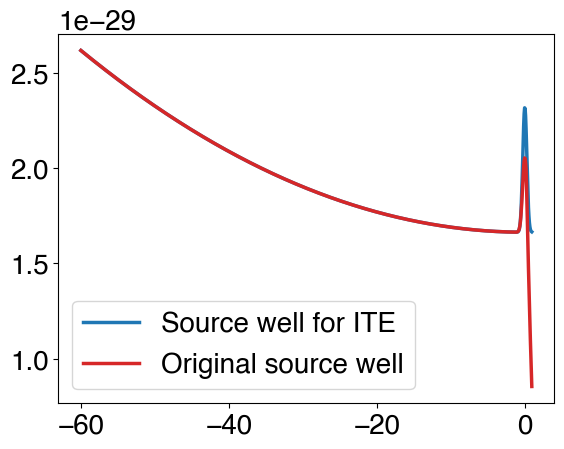

In [8]:
dx = np.ptp(position_arr)/N
source_well_position = np.arange(position_start*1.e-6, (gate_well_start+1.0)*1.e-6, dx)*1.e6
A = 0.004 # Increasing A results in increase in left side of the source well.
B = 0.15 # Increasing B results in increase in width of the source well.
initial_SG_barrier_height = 35
V_SS = source_bias
initial_source_well_potential = source_well_potential_function(source_well_position, A, B, initial_SG_barrier_height - V_SS,V_SS)*10**3*H_BAR*2*PI  # In SI units.
plt.plot(source_well_position, initial_source_well_potential, label = "Source well for ITE", color = "tab:blue", linewidth = 2.5)
#plt.scatter(source_well_position, source_well_potential, color = "tab:blue", s = 20)
plt.plot(source_well_position, complete_transistor_potential[:len(source_well_position)], label = "Original source well", color = "tab:red", linewidth = 2.5)
#plt.scatter(source_well_position, complete_transistor_potential[:len(source_well_position)], color = "tab:red", s = 20)
plt.legend()
plt.show()

# Initial ground state in the source well

In [9]:
number_of_atoms = 30000

In [10]:
time_step = -1j*10**(-6) # In seconds unit.
tmax = 1 # In seconds unit.
solver_source_well = GrossPitaevskiiSolver(time_step, tmax, source_well_position*1.e-6, initial_source_well_potential, number_of_atoms, None)
psi_source_well_ITE_dimless = solver_source_well.solve([])

Gross-Pitaevskii equation is valid: 5.223827252974923e-06 << 1
Initial wavefunction is not provided. Using a Gaussian wavefunction as the initial wavefunction.
Total iterations:  1000000
Normalization of the final single particle wavefunction:  0.9999999999999999
Number of atoms in the trap =  29999.999999999996


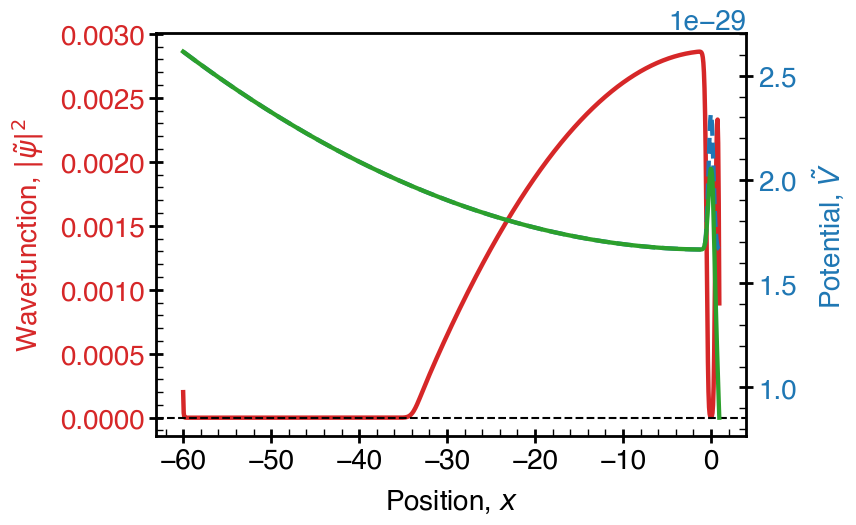

In [11]:
data0 = source_well_position
data1 = psi_source_well_ITE_dimless
data3 = initial_source_well_potential

fig, ax1 = plt.subplots()

ax1.set_xlabel(r"Position, $x$", labelpad=10)
ax1.set_ylabel(r"Wavefunction, $|\tilde{\psi}|^{2}$", color="tab:red", labelpad=10)
ax1.plot(data0, np.abs(data1)**2*solver_source_well.dx_dimless, color="tab:red", linewidth=3.2)
ax1.tick_params(axis="y", labelcolor="tab:red")
ax2 = ax1.twinx()

color = "tab:blue"
ax2.set_ylabel(r"Potential, $\tilde{V}$ ", color=color, labelpad=10)
ax2.plot(data0, data3, linewidth=3.1, color = "tab:blue", linestyle="--")
ax2.plot(data0,complete_transistor_potential[:len(source_well_position)], linewidth=3.1, color = "tab:green")
ax2.tick_params(axis="y", labelcolor=color)
ax1.axhline(y=0, color="k", linestyle='--')

fig.set_figwidth(8.6)
fig.set_figheight(8.6/1.618)
fig.tight_layout(pad=1.0)  # Adjust padding to ensure labels are not cut off

for spine in ax1.spines.values():
    spine.set_linewidth(2)
ax1.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
ax1.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
ax2.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
ax2.tick_params(axis="y", direction="inout", length=10, width=2, color="k")

ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.tick_params(which="minor", length=5, width=1, direction='in')   

ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.tick_params(which="minor", length=5, width=1, direction='in')   
# Change the directory to save the PDF
# path = "/Users/sasankadowarah/atomtronics/cluster-codes/harmonic_gate_well"
# os.chdir(path)
# Save the figure
#plt.savefig("ground_state_in_source_well.pdf", dpi=600, bbox_inches='tight')

Thomas Fermi limit is valid. Ratio KE/PE =  0.00020581811720479456  << 1
Chemical potential in the source well =  1.9708730261328478e-29 (J) or 29.745504980416108 (kHz)


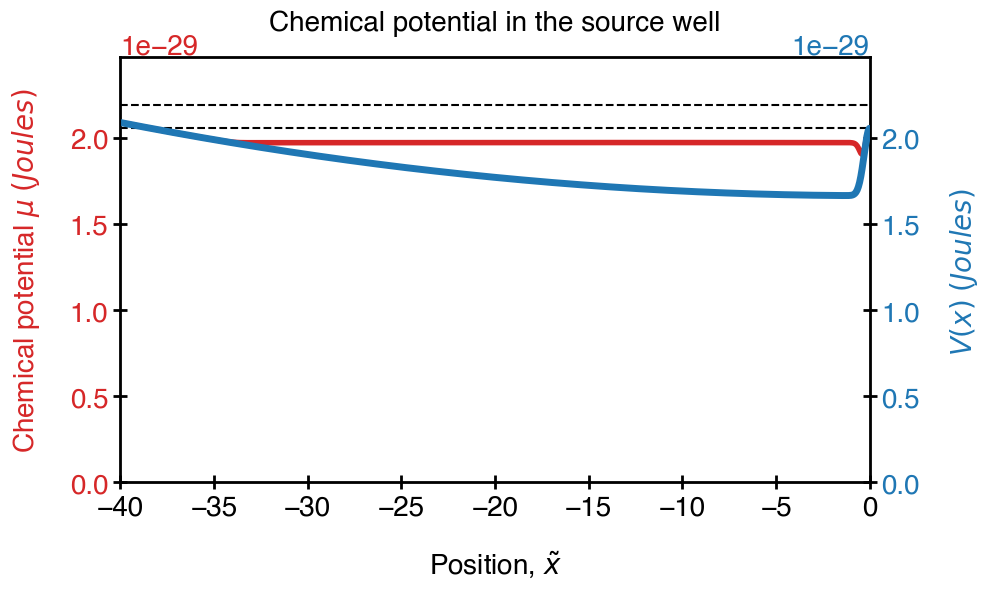

In [12]:
data0 = source_well_position
source_well_potential = complete_transistor_potential[0:len(source_well_position)]

# Checking the validity of chemical potential calculation.
# Kinetic energy term.
psi_k_dimless = fftpack.fft(psi_source_well_ITE_dimless)
psi_k_dimless = psi_k_dimless/np.sqrt(np.sum(np.abs(psi_k_dimless)**2)*solver_source_well.dx_dimless)
kinetic_energy_term = np.sum(solver_source_well.kinetic_energy_dimless() * np.abs(psi_k_dimless)**2)*solver_source_well.dx_dimless
# Potential energy term.
potential_energy_term = np.sum(source_well_potential/(solver_source_well.h_bar*solver_source_well.omega_l) * np.abs(psi_source_well_ITE_dimless)**2)*solver_source_well.dx_dimless + (solver_source_well.g_dimless)*np.sum(np.abs(psi_source_well_ITE_dimless)**2)*solver_source_well.dx_dimless
if kinetic_energy_term < potential_energy_term:
    print("Thomas Fermi limit is valid. Ratio KE/PE = ", kinetic_energy_term/potential_energy_term," << 1")
else:
    print("Thomas Fermi limit is not valid. Ratio KE/PE = ", kinetic_energy_term/potential_energy_term, ">> 1")

# Chemical potential calculation.
data1 = source_well_potential + 2*(solver_source_well.h_bar*solver_source_well.omega_r*solver_source_well.a_s*solver_source_well.number_of_atoms)*np.abs(psi_source_well_ITE_dimless/np.sqrt(solver_source_well.l_0))**2
data3 = source_well_potential 

fig, ax1 = plt.subplots()
ax1.set_xlabel(r"Position, $\tilde{x}$", labelpad=20)
ax1.set_ylabel(r"Chemical potential $\mu\; (Joules)$", color="tab:red", labelpad=20)
ax1.plot(data0, data1, color="tab:red",linewidth = 4)
plt.title(r"Chemical potential in the source well")
#plt.legend()
ax1.tick_params(axis="y", labelcolor="tab:red")
ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel(r"$V(x)\; (Joules)$ ", color=color,  labelpad=20)
ax2.plot(data0, data3, color=color,linewidth = 5)
ax2.tick_params(axis="y", labelcolor=color)
fig.set_figwidth(10)
fig.set_figheight(6)
plt.subplots_adjust(bottom=0.2)
for spine in ax1.spines.values():
    spine.set_linewidth(2)
ax1.set_xlim([-40,0])    
ax2.set_ylim([  0, barrier_height_SG * 10**3*H_BAR*2*PI*1.2 ])
ax1.set_ylim([0, barrier_height_SG*10**3*H_BAR*2*PI*1.2 ])
ax1.axhline(y = barrier_height_GD * 10**3*H_BAR*2*PI , color="k", linestyle='--')
ax1.axhline(y = barrier_height_SG * 10**3*H_BAR*2*PI , color="k", linestyle='--')
ax1.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
ax1.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
ax2.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
ax2.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
print("Chemical potential in the source well = ", data1[len(data1)//2],"(J) or",data1[int(len(data1)/1.1)]/(H_BAR*10**3*2*PI), "(kHz)")
#ax1.set_xlim([-4,0])
#plt.savefig("chemical_potential_in_source_well_16_1000_"+str(NUMBER_OF_ATOMS)+".jpg", dpi=600)
fig.tight_layout()

In [ ]:
a_perp = np.sqrt(solver_source_well.h_bar/(solver_source_well.atom_mass*solver_source_well.omega_r))
a_z = np.sqrt(solver_source_well.h_bar/(solver_source_well.atom_mass*solver_source_well.omega_l))
Xi = solver_source_well.number_of_atoms*solver_source_well.a_s*(a_perp/a_z**2)
mu_1d = (solver_source_well.h_bar*solver_source_well.omega_r/2)*(2+(3*Xi)**(2/3))
mu_1d/(H_BAR*10**3*2*PI) + source_bias

# Real time evolution

In [ ]:
# Put the initial ground state in the source well of the transistor.
psi_initial_for_full_potential_dimless = psi_source_well_ITE_dimless
while len(psi_initial_for_full_potential_dimless) < len(position_arr):
    psi_initial_for_full_potential_dimless = np.hstack((psi_initial_for_full_potential_dimless, np.array([0])))

time_step = 10**(-7) # In seconds unit.
tmax = 200*1.e-3 # In seconds unit.

time_lst = list(np.arange(0.0,tmax,0.1*1.e-3))

solver_complete_potential = GrossPitaevskiiSolver(time_step, tmax, position_arr, complete_transistor_potential, number_of_atoms, psi_initial_for_full_potential_dimless)
time_evolved_wavefunction_time_split = solver_complete_potential.solve(time_lst)

# Plot Wavefunction as Function of Time

In [ ]:
# Plotting the potential landscape and the time evolved wavefunction in the same plot using two axes.
fig, ax1 = plt.subplots()

ax1.set_xlabel(r"Position, $x$", labelpad=10)
ax1.set_ylabel(r"Wavefunction, $|\psi|^{2}$", color="tab:red", labelpad=10)
ax1.plot(position_arr*1.e6, np.abs(time_evolved_wavefunction_time_split)**2*solver_complete_potential.dx_dimless, color="tab:red", linewidth=3.2)
#ax1.scatter(position_arr*1.e6, np.abs(time_evolved_wavefunction_time_split)**2*solver_complete_potential.dx_dimless, color="tab:red", s = 20)
ax1.tick_params(axis="y", labelcolor="tab:red")
ax2 = ax1.twinx()

color = "tab:blue"
ax2.set_ylabel(r"Potential, $V(x)$ ", color=color, labelpad=10)
ax2.plot(position_arr*1.e6, complete_transistor_potential/(10**3*H_BAR*2*PI), color=color, linewidth=3.1)
# ax2.scatter(position_arr*1.e6, complete_transistor_potential/(10**3*H_BAR*2*PI), color=color, s = 20)
ax2.set_xlim([-60, 30])
ax2.set_ylim([0, barrier_height_GD*1.2]) # In kHz units.
ax2.tick_params(axis="y", labelcolor=color)
ax1.axhline(y=0, color="k", linestyle='--')

fig.set_figwidth(14)
fig.set_figheight(5)
fig.tight_layout(pad=1.0)  # Adjust padding to ensure labels are not cut off

for spine in ax1.spines.values():
     spine.set_linewidth(2)
ax1.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
ax1.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
ax2.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
ax2.tick_params(axis="y", direction="inout", length=10, width=2, color="k")

ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.tick_params(which="minor", length=5, width=1, direction='in')

ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.tick_params(which="minor", length=5, width=1, direction='in')
fig.tight_layout()
plt.show()

# Coherent Oscillation of Position Operator

In [ ]:
# Array to store the position expectation value of the wavefunction at each time.
position_expectation_values = np.zeros(len(time_lst), dtype=complex)
# gate_well_start_index = np.where(np.abs(solver_complete_potential.position_arr - gate_well_start) < 1.e-7)[0][0]
# gate_well_end_index = np.where(np.abs(solver_complete_potential.position_arr - gate_well_end*1.e-6) < 1.e-7)[0][0]

mask = (solver_complete_potential.position_arr >= 10*1.e-6) & (solver_complete_potential.position_arr <= 20*1.e-6)
x_gate = solver_complete_potential.position_arr[mask]
x_gate_dimless = x_gate/solver_complete_potential.x_s

time_lst_to_plot = []
for i, time in enumerate(time_lst[10:-100]):
     path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
     os.chdir(path)
     time_lst_to_plot.append(time*1.e3)
     psi_t_dimless = np.load(f"wavefunction_time_evolved_{time*1e3:.3f}ms.npy")
     psi_t_dimless_gate = psi_t_dimless[mask]
     position_expectation_values[i] = np.trapz(np.conj(psi_t_dimless_gate) * x_gate_dimless * psi_t_dimless_gate, x_gate_dimless)
     #position_expectation_values[i] = np.trapz(x_gate_dimless * np.abs(psi_t_dimless_gate)**2, x_gate_dimless)

# Momentum expectation value calculation for the wavefunction in the gate well.
#dpsi_dx = np.gradient(psi, x)     

In [ ]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(3)
plt.plot(position_expectation_values.real)
plt.show()

In [ ]:
from scipy.fft import fft, fftfreq, fftshift

def fft_analysis(signal):
     signal = position_expectation_values.real
     signal = signal - np.mean(signal)
     signal = signal/np.max(signal)
     n = len(signal)
     fft_result = fft(signal)
     dt = 0.01*1.e-3
     frequencies = fftfreq(n, d=dt)
     fft_result_shifted = fftshift(fft_result)
     frequencies_shifted = fftshift(frequencies)
     power_spectrum = np.abs(fft_result_shifted) ** 2
     peak_indices = np.argsort(-power_spectrum)[:20]  # Get top 20 peaks
     dominant_frequencies = frequencies_shifted[peak_indices]
     dominant_powers = power_spectrum[peak_indices]
     return frequencies_shifted, power_spectrum, peak_indices, dominant_frequencies, dominant_powers

position_frequencies_shifted, position_power_spectrum, position_peak_indices, position_dominant_frequencies, position_dominant_powers = fft_analysis(position_expectation_values.real)

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(3)
plt.plot(2 * np.pi * position_frequencies_shifted, position_power_spectrum, linewidth=4, color=color)
plt.scatter(2 * np.pi * position_frequencies_shifted[position_peak_indices], position_power_spectrum[position_peak_indices],
          color="k", s=100, marker="o", label="Dominant Frequencies")
plt.axvline(x=single_particle_omega, color="tab:red", linestyle='--', linewidth=3.1)          
plt.xlim([0, 10000])          
for i in range(len(position_dominant_frequencies)):
    print(f"Dominant frequency: {2*np.pi*position_dominant_frequencies[i]:.2f} rad/s, Power: {position_dominant_powers[i]}")
plt.show()

In [ ]:
# path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
# os.chdir(path)
# source_lst = np.load("source_well_atom_number_arr.npy")
# gate_lst = np.load("gate_well_atom_number_arr.npy")
# drain_lst = np.load("drain_well_atom_number_arr.npy")

# source_lst = np.array(source_lst)
# gate_lst = np.array(gate_lst)
# drain_lst = np.array(drain_lst)

# time_lst = np.array(time_lst)
# #plt.plot(time_lst, source_lst, label = "Source well", linewidth = 2.5)
# #plt.plot(time_lst, gate_lst, label = "Gate well", linewidth = 2.5)
# plt.plot(time_lst, drain_lst, label = "Drain well", linewidth = 2.5)
# plt.xlabel(r"Time, $t\; (ms)$",labelpad=10)
# plt.ylabel(r"Number of atoms",labelpad=10)
# plt.legend()
# plt.show()

# FFT of the drain well wavefunction

In [ ]:
path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
os.chdir(path)
transistor_position_arr= np.load("transistor_position_arr.npy")

def find_index_of_fixed_position(array, fixed_position, atol=1e-7, rtol=1e-7):
    """Finds the index of the closest element in the array to the fixed position.

    Args:
        array: The array to search.
        fixed_position: The fixed position to find.
        atol: The absolute tolerance for the comparison.
        rtol: The relative tolerance for the comparison.

    Returns:
        The index of the closest element.

    Raises:
        ValueError: If the fixed position is not found within the tolerance.
    """
    indices = np.where(np.isclose(array, fixed_position, atol=atol, rtol=rtol))[0]
    if len(indices) == 0:
        raise ValueError("Fixed position not found within tolerance.")
    return indices[0]  # Return the first index if multiple matches are found

fixed_position_in_source_well = -5 * 1e-6  # In micrometers unit
fixed_position_in_gate_well = 4 * 1e-6  # In micrometers unit
fixed_position_in_drain_well = 10 * 1e-6  # In micrometers unit

index_of_fixed_point_source_well = find_index_of_fixed_position(transistor_position_arr, fixed_position_in_source_well)
index_of_fixed_point_gate_well = find_index_of_fixed_position(transistor_position_arr, fixed_position_in_gate_well)
index_of_fixed_point_drain_well = find_index_of_fixed_position(transistor_position_arr, fixed_position_in_drain_well)

wavefunction_at_fixed_point_source_arr = []
wavefunction_at_fixed_point_gate_arr = []
wavefunction_at_fixed_point_drain_arr = []

tmax_new = tmax - 1*1.e-3 # In seconds unit.
time_lst = list(np.arange(0.0, tmax_new, 0.001*1.e-3))

for time in time_lst:
     print(f"Collecting wavefuncton at time = {time*1e3:.3f} ms")
     time_evolved_wavefunction_time_split_dimless = np.load(f"wavefunction_time_evolved_{time*1e3:.3f}ms.npy")
     wavefunction_at_fixed_point_source_arr.append(time_evolved_wavefunction_time_split_dimless[index_of_fixed_point_source_well])
     wavefunction_at_fixed_point_gate_arr.append(time_evolved_wavefunction_time_split_dimless[index_of_fixed_point_gate_well])
     wavefunction_at_fixed_point_drain_arr.append(time_evolved_wavefunction_time_split_dimless[index_of_fixed_point_drain_well]) 

In [16]:
# wavefunction_at_fixed_point_source_arr = np.load("wavefunction_at_fixed_point_source_arr.npy")
# wavefunction_at_fixed_point_gate_arr = np.load("wavefunction_at_fixed_point_gate_arr.npy")
# wavefunction_at_fixed_point_drain_arr = np.load("wavefunction_at_fixed_point_drain_arr.npy")

density_source = np.abs(wavefunction_at_fixed_point_source_arr)**2 - np.mean(np.abs(wavefunction_at_fixed_point_source_arr)**2)
density_gate = np.abs(wavefunction_at_fixed_point_gate_arr)**2 - np.mean(np.abs(wavefunction_at_fixed_point_gate_arr)**2)
density_drain = np.abs(wavefunction_at_fixed_point_drain_arr)**2 - np.mean(np.abs(wavefunction_at_fixed_point_drain_arr)**2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
import matplotlib.ticker as ticker

# Set font parameters
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]

# Time interval in seconds (dt in milliseconds converted to seconds)
dt = 0.001 * 1.e-3

def plot_power_spectrum(ax, signal, title, single_particle_omega):
    """ Function to compute FFT and plot the power spectrum on a given axis. """
    signal = signal / np.max(signal)  # Normalize the signal
    signal = signal - np.mean(signal)  # Remove DC component
    n = len(signal)
    fft_result = fft(signal)
    frequencies = fftfreq(n, d=dt)  # Frequency in Hz
    fft_result_shifted = fftshift(fft_result)
    frequencies_shifted = fftshift(frequencies)
    power_spectrum = np.abs(fft_result_shifted) ** 2

    # Find dominant frequencies
    peak_indices = np.argsort(-power_spectrum)[:20]  # Get top 20 peaks
    dominant_frequencies = frequencies_shifted[peak_indices]
    dominant_powers = power_spectrum[peak_indices]

    # Plot the power spectrum
    ax.plot(2 * np.pi * frequencies_shifted, power_spectrum, linewidth=3.5, color="tab:red")
    ax.scatter(2 * np.pi * frequencies_shifted[peak_indices], power_spectrum[peak_indices],
               color="k", s=100, marker="o", label="Dominant Frequencies")
    ax.set_xlabel("Angular Frequency (rad/s)", labelpad=10)
    ax.set_ylabel("Power Spectrum", labelpad=10)
    ax.set_title(title)
    ax.set_xlim([0, 10000])
    ax.axvline(x=single_particle_omega, color="tab:green", linestyle="--", linewidth=3.5)
    ax.axvline(x=2*single_particle_omega, color="tab:blue", linestyle="--", linewidth=3.5)
    
    # Formatting axes
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
    ax.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which="minor", length=5, width=1, direction='in')

    # Print the dominant frequencies and powers
    positive_dominant_freqs = dominant_frequencies[dominant_frequencies > 0]
    positive_dominant_powers = dominant_powers[dominant_frequencies > 0]
    omega = 2 * np.pi * positive_dominant_freqs
    # print(f"Dominant Frequencies and Powers for {title}:")
    # for freq, power in zip(omega, positive_dominant_powers):
    #     print(f"Angular Frequency (rad/s): {freq:.2f}, Power: {power:.2e}")

fig, axs = plt.subplots(1, 3, figsize=(23, 6))  # 1 row, 3 columns for side-by-side plots
plot_power_spectrum(axs[0], density_source, "Power Spectrum of the Source Well", single_particle_omega)
plot_power_spectrum(axs[1], density_gate, "Power Spectrum of the Gate Well", single_particle_omega)
plot_power_spectrum(axs[2], density_drain, "Power Spectrum of the Drain Well", single_particle_omega)
fig.tight_layout()
# path ="/Users/sasankadowarah/atomtronics/triple-well-transistor/coherence_test_29092024_0/"
# os.chdir(path)
# plt.savefig("power_spectrum_source_gate_drain_vss"+str(source_bias)+"3.png", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
# # matplotlib parameters 
# large = 40; med = 25; small = 20
# params = {'axes.titlesize': med,
#           'axes.titlepad' : med,
#           'legend.fontsize': med,
#           'axes.labelsize': med ,
#           'axes.titlesize': med ,
#           'xtick.labelsize': med ,
#           'ytick.labelsize': med ,
#           'figure.titlesize': med}
# plt.rcParams["font.family"] = "Helvetica"
# plt.rcParams["font.serif"] = ["Helvetica Neue"]          
# #plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
# plt.rcParams.update(params)

# tinit = 0.0*1.e-3
# tmax = 60*1.e-3 # In seconds unit.

# time_lst = np.arange(0.0*1.e-3,tmax,0.001*1.e-3)

# density_source = np.abs(wavefunction_at_fixed_point_source_arr)**2 - np.mean(np.abs(wavefunction_at_fixed_point_source_arr)**2)
# density_gate = np.abs(wavefunction_at_fixed_point_gate_arr)**2 - np.mean(np.abs(wavefunction_at_fixed_point_gate_arr)**2)
# density_drain = np.abs(wavefunction_at_fixed_point_drain_arr)**2 - np.mean(np.abs(wavefunction_at_fixed_point_drain_arr)**2)

# index_closest = np.argmin(np.abs(time_lst - tinit))
# density_source = density_source[index_closest:len(time_lst)]
# density_gate = density_gate[index_closest:len(time_lst)]
# density_drain = density_drain[index_closest:len(time_lst)]

# # Create a figure and a set of subplots
# fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 9))

# # Plotting each array in a separate subplot
# axs[0].plot(np.array(time_lst[index_closest:len(time_lst)])*1.e3,density_source/np.max(density_source), color="tab:red", linewidth = 2.8, label="Source")
# axs[0].set_xlabel("Time (ms)")
# axs[0].set_ylabel("$|\psi(t)|^{2}$")
# #axs[0].set_title("Source Atom Number vs. Time")

# axs[1].plot(np.array(time_lst[index_closest:len(time_lst)])*1.e3, density_gate/np.max(density_gate) , color="tab:blue",linewidth = 2.8, label="Gate")
# axs[1].set_xlabel("Time (ms)")
# axs[1].set_ylabel("$|\psi(t)|^{2}$")
# #axs[1].set_title("Gate Atom Number vs. Time")

# axs[2].plot(np.array(time_lst[index_closest:len(time_lst)])*1.e3, density_drain/np.max(density_drain) , color="tab:green",linewidth = 2.8, label="Drain")
# axs[2].set_xlabel("Time (ms)")
# axs[2].set_ylabel("$|\psi(t)|^{2}$")
# #axs[2].set_title("Drain Atom Number vs. Time")

# # Adding a legend
# axs[0].legend()
# axs[1].legend()
# axs[2].legend()

# for spine in axs[0].spines.values():
#     spine.set_linewidth(2)
# for spine in axs[1].spines.values():
#     spine.set_linewidth(2)   
# for spine in axs[2].spines.values():
#     spine.set_linewidth(2)   
# for i in range(3):     
#      axs[i].tick_params(axis="x", direction="inout", length=10, width=2, color="k")
#      axs[i].tick_params(axis="y", direction="inout", length=10, width=2, color="k")
#      axs[i].tick_params(axis="x", direction="inout", length=10, width=2, color="k")
#      axs[i].tick_params(axis="y", direction="inout", length=10, width=2, color="k")

# for i in range(3):
#     axs[i].tick_params(axis="x", direction="inout", length=10, width=2, color="k")
#     axs[i].tick_params(axis="y", direction="inout", length=10, width=2, color="k")
#     axs[i].tick_params(axis="x", direction="inout", length=10, width=2, color="k")
#     axs[i].tick_params(axis="y", direction="inout", length=10, width=2, color="k")
    
#     # Plot vertical lines at every 0.88 interval
#     x_values = np.arange(tinit*1.e3, tmax*1.e3, 0.88)
#     for x in x_values:
#         axs[i].axvline(x, color='k', linestyle='--', linewidth=0.5)
# plt.tight_layout()
# # path ="/Users/sasankadowarah/atomtronics/triple-well-transistor/coherence_test_29092024_0"
# # os.chdir(path)
# # plt.savefig("wavefunction_density_at_fixed_spatial_points_"+str(tmax*1.e3)+".png", dpi=600)
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.fft import fft, fftfreq, fftshift
# import matplotlib.ticker as ticker

# # Set font parameters
# plt.rcParams["font.family"] = "Helvetica"
# plt.rcParams["font.serif"] = ["Helvetica Neue"]

# # Time interval in seconds (dt in milliseconds converted to seconds)
# dt = 0.001 * 1.e-3

# def plot_power_spectrum(ax, signal, title, single_particle_omega):
#     """ Function to compute FFT and plot the power spectrum on a given axis. """
#     signal = signal / np.max(signal)  # Normalize the signal
#     signal = signal - np.mean(signal)  # Remove DC component
#     n = len(signal)
#     fft_result = fft(signal)
#     frequencies = fftfreq(n, d=dt)  # Frequency in Hz
#     fft_result_shifted = fftshift(fft_result)
#     frequencies_shifted = fftshift(frequencies)
#     power_spectrum = np.abs(fft_result_shifted) ** 2

#     # Find dominant frequencies
#     peak_indices = np.argsort(-power_spectrum)[:20]  # Get top 20 peaks
#     dominant_frequencies = frequencies_shifted[peak_indices]
#     dominant_powers = power_spectrum[peak_indices]

#     # Plot the power spectrum
#     ax.plot(2 * np.pi * frequencies_shifted, power_spectrum, linewidth=3.5, color="tab:red")
#     ax.scatter(2 * np.pi * frequencies_shifted[peak_indices], power_spectrum[peak_indices],
#                color="k", s=100, marker="o", label="Dominant Frequencies")
#     ax.set_xlabel("Angular Frequency (rad/s)", labelpad=10)
#     ax.set_ylabel("Power Spectrum", labelpad=10)
#     ax.set_title(title)
#     ax.set_xlim([0, 10000])
#     ax.axvline(x=single_particle_omega, color="tab:green", linestyle="--", linewidth=3.5)
    
#     # Formatting axes
#     for spine in ax.spines.values():
#         spine.set_linewidth(2)
#     ax.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
#     ax.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
#     ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
#     ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
#     ax.tick_params(which="minor", length=5, width=1, direction='in')

#     # Print the dominant frequencies and powers
#     positive_dominant_freqs = dominant_frequencies[dominant_frequencies > 0]
#     positive_dominant_powers = dominant_powers[dominant_frequencies > 0]
#     omega = 2 * np.pi * positive_dominant_freqs
#     # print(f"Dominant Frequencies and Powers for {title}:")
#     # for freq, power in zip(omega, positive_dominant_powers):
#     #     print(f"Angular Frequency (rad/s): {freq:.2f}, Power: {power:.2e}")

# fig, axs = plt.subplots(1, 3, figsize=(23, 6))  # 1 row, 3 columns for side-by-side plots
# plot_power_spectrum(axs[0], density_source, "Power Spectrum of the Source Well", single_particle_omega)
# plot_power_spectrum(axs[1], density_gate, "Power Spectrum of the Gate Well", single_particle_omega)
# plot_power_spectrum(axs[2], density_drain, "Power Spectrum of the Drain Well", single_particle_omega)
# fig.tight_layout()
# # path ="/Users/sasankadowarah/atomtronics/triple-well-transistor/coherence_test_29092024_0/"
# # os.chdir(path)
# # plt.savefig("power_spectrum_source_gate_drain_"+str(tmax*1.e3)+".png", dpi=600)
# plt.show()

# Atom Number as Function of Time

In [ ]:
"""
Given a time and index of the source bias potential the following
function calculates the number of atoms in the source; gate and
the drain well.

"""
def source_atom_number(final_time):
     path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
     os.chdir(path)
     wavefunction_dimless = np.load(f"wavefunction_time_evolved_{time*1e3:.3f}ms.npy")    
     psi_lst_dimless = []
     for i in range(N):
          if source_well_start <= (position_arr*1.e6)[i] <= gate_well_start:
               psi_lst_dimless.append(wavefunction_dimless[i])
     return int(number_of_atoms*np.sum(np.abs(psi_lst_dimless)**2)*solver_complete_potential.dx_dimless)

def gate_atom_number(final_time):
     path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
     os.chdir(path)
     wavefunction_dimless = np.load(f"wavefunction_time_evolved_{time*1e3:.3f}ms.npy")    
     psi_lst_dimless = []
     for i in range(N):
          if gate_well_start <= (position_arr*1.e6)[i] <= gate_well_end:
               psi_lst_dimless.append(wavefunction_dimless[i])
     return int(number_of_atoms*np.sum(np.abs(psi_lst_dimless)**2)*solver_complete_potential.dx_dimless)   

def drain_atom_number(final_time):
     path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
     os.chdir(path)
     wavefunction_dimless = np.load(f"wavefunction_time_evolved_{time*1e3:.3f}ms.npy")    
     psi_lst_dimless = []
     for i in range(N):
          if gate_well_end <= (position_arr*1.e6)[i] <= position_end:
               psi_lst_dimless.append(wavefunction_dimless[i])
     return int(number_of_atoms*np.sum(np.abs(psi_lst_dimless)**2)*solver_complete_potential.dx_dimless)

time_step = 10**(-7) # In seconds unit.
tmax = 100*1.e-3 # In seconds unit.

time_lst = list(np.arange(0.0,tmax,0.01*1.e-3))

source_atom_number_lst = []
gate_atom_number_lst = []
drain_atom_number_lst = []

for time in time_lst:
     source_atom_number_lst.append(source_atom_number(time))
     gate_atom_number_lst.append(gate_atom_number(time))
     drain_atom_number_lst.append(drain_atom_number(time))     

In [ ]:
path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
os.chdir(path)
source_atom_number_lst = np.load("source_well_atom_number_arr.npy")
gate_atom_number_lst = np.load("gate_well_atom_number_arr.npy")
drain_atom_number_lst = np.load("drain_well_atom_number_arr.npy")

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 3*5))

# Plotting each array in a separate subplot
axs[0].plot(np.array(time_lst)*1.e3, source_atom_number_lst, color="tab:red", linewidth = 3.1, label="Source")
#axs[0].scatter(time_lst, source_atom_number_lst, color="tab:red", s = 100)
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Atom number")
#axs[0].set_title("Source Atom Number vs. Time")

axs[1].plot(np.array(time_lst)*1.e3, gate_atom_number_lst, color="tab:blue",linewidth = 3.1, label="Gate")
#axs[1].scatter(time_lst, gate_atom_number_lst, color="tab:blue", s = 100)
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Atom number")
#axs[1].set_title("Gate Atom Number vs. Time")

axs[2].plot(np.array(time_lst)*1.e3, drain_atom_number_lst, color="tab:green",linewidth = 3.1, label="Drain")
#axs[2].scatter(time_lst, drain_atom_number_lst, color="tab:green", s = 100)
axs[2].set_xlabel("Time (ms)")
axs[2].set_ylabel("Atom number")
#axs[2].set_title("Drain Atom Number vs. Time")

# Adding a legend
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Plotting grid.
axs[0].grid()
axs[1].grid()
axs[2].grid()

for spine in axs[0].spines.values():
    spine.set_linewidth(2)
for spine in axs[1].spines.values():
    spine.set_linewidth(2)   
for spine in axs[2].spines.values():
    spine.set_linewidth(2)   
for i in range(3):     
     axs[i].tick_params(axis="x", direction="inout", length=10, width=2, color="k")
     axs[i].tick_params(axis="y", direction="inout", length=10, width=2, color="k")
     axs[i].tick_params(axis="x", direction="inout", length=10, width=2, color="k")
     axs[i].tick_params(axis="y", direction="inout", length=10, width=2, color="k")
plt.tight_layout()
# path ="/Users/sasankadowarah/atomtronics/triple-well-transistor/"
# os.chdir(path)
# plt.savefig("harmonic_gate_well_V_SS_"+str(source_bias)+".jpg", dpi=600)
plt.show()